In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ProductivityPrediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Load the data
data = spark.read.csv('cleaned_data.csv', header=True, inferSchema=True)
data = data.withColumn("date", col("date").cast("date"))

# Show the schema
data.printSchema()

# Show the first few rows
data.show(5)

root
 |-- date: date (nullable = true)
 |-- quarter: string (nullable = true)
 |-- department: string (nullable = true)
 |-- day: string (nullable = true)
 |-- team: integer (nullable = true)
 |-- targeted_productivity: double (nullable = true)
 |-- smv: double (nullable = true)
 |-- wip: double (nullable = true)
 |-- over_time: integer (nullable = true)
 |-- incentive: integer (nullable = true)
 |-- idle_time: double (nullable = true)
 |-- idle_men: integer (nullable = true)
 |-- no_of_style_change: integer (nullable = true)
 |-- no_of_workers: double (nullable = true)
 |-- actual_productivity: double (nullable = true)

+----+--------+----------+--------+----+---------------------+-----+------+---------+---------+---------+--------+------------------+-------------+-------------------+
|date| quarter|department|     day|team|targeted_productivity|  smv|   wip|over_time|incentive|idle_time|idle_men|no_of_style_change|no_of_workers|actual_productivity|
+----+--------+----------+--------+

In [4]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, Binarizer

# Binarize the label column for classification
binarizer = Binarizer(inputCol="actual_productivity", outputCol="label_binary", threshold=0.5)
data = binarizer.transform(data)

# Assemble features for classification
feature_columns_classification = ['team', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
assembler_classification = VectorAssembler(inputCols=feature_columns_classification, outputCol="features_classification")
data = assembler_classification.transform(data)

# Assemble features for regression
assembler_regression = VectorAssembler(inputCols=feature_columns_classification, outputCol="features_regression")
data = assembler_regression.transform(data)

# Index the label column for classification
indexer = StringIndexer(inputCol="label_binary", outputCol="indexedLabel")
data = indexer.fit(data).transform(data)

# Select necessary columns
data_classification = data.select("features_classification", "indexedLabel")
data_regression = data.select("features_regression", "actual_productivity")

# Show the transformed data
data_classification.show(5)
data_regression.show(5)

+-----------------------+------------+
|features_classification|indexedLabel|
+-----------------------+------------+
|   [8.0,26.16,1108.0...|         0.0|
|   (9,[0,1,3,8],[1.0...|         0.0|
|   [11.0,11.41,968.0...|         0.0|
|   [12.0,11.41,968.0...|         0.0|
|   [6.0,25.9,1170.0,...|         0.0|
+-----------------------+------------+
only showing top 5 rows

+--------------------+-------------------+
| features_regression|actual_productivity|
+--------------------+-------------------+
|[8.0,26.16,1108.0...|        0.940725424|
|(9,[0,1,3,8],[1.0...|             0.8865|
|[11.0,11.41,968.0...|        0.800570492|
|[12.0,11.41,968.0...|        0.800570492|
|[6.0,25.9,1170.0,...|        0.800381944|
+--------------------+-------------------+
only showing top 5 rows



In [5]:
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features_classification", labelCol="indexedLabel")
rf_model_classifier = rf_classifier.fit(data_classification)
predictions_rf_classifier = rf_model_classifier.transform(data_classification)

# Evaluate Random Forest Classifier
evaluator_class = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_class.evaluate(predictions_rf_classifier)
print(f"Random Forest Classifier Accuracy: {accuracy_rf}")

# Linear SVM
svm = LinearSVC(featuresCol="features_classification", labelCol="indexedLabel")
svm_model = svm.fit(data_classification)
predictions_svm = svm_model.transform(data_classification)

# Evaluate Linear SVM
accuracy_svm = evaluator_class.evaluate(predictions_svm)
print(f"SVM Accuracy: {accuracy_svm}")

Random Forest Classifier Accuracy: 0.8955722639933166
SVM Accuracy: 0.8922305764411027


In [6]:
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Random Forest Regressor
rf_regressor = RandomForestRegressor(featuresCol="features_regression", labelCol="actual_productivity")
rf_model_regressor = rf_regressor.fit(data_regression)
predictions_rf_regressor = rf_model_regressor.transform(data_regression)

# Evaluate Random Forest Regressor
evaluator_reg = RegressionEvaluator(labelCol="actual_productivity", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator_reg.evaluate(predictions_rf_regressor)
print(f"Random Forest Regressor RMSE: {rmse_rf}")

# Linear Regression
lr = LinearRegression(featuresCol="features_regression", labelCol="actual_productivity")
lr_model = lr.fit(data_regression)
predictions_lr = lr_model.transform(data_regression)

# Evaluate Linear Regression
rmse_lr = evaluator_reg.evaluate(predictions_lr)
print(f"Linear Regression RMSE: {rmse_lr}")

Random Forest Regressor RMSE: 0.12764445987752526
Linear Regression RMSE: 0.16232179691942022


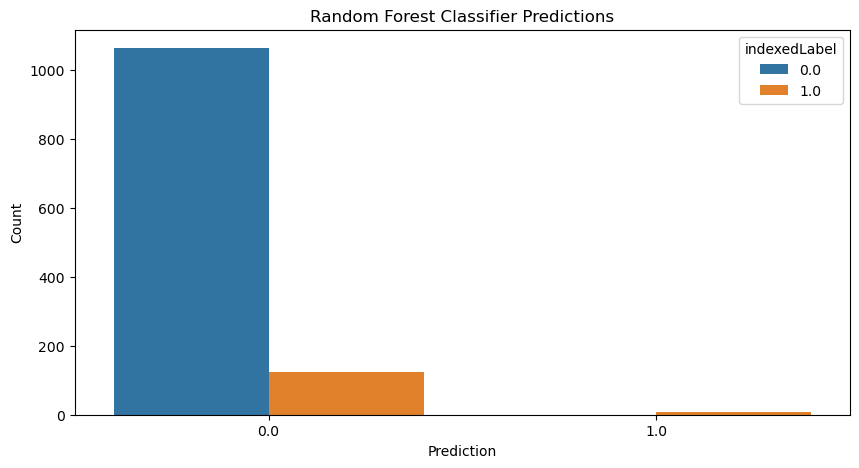

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization for Random Forest Classifier
pdf_rf_classifier = predictions_rf_classifier.select("prediction", "indexedLabel").toPandas()
plt.figure(figsize=(10, 5))
sns.countplot(x="prediction", hue="indexedLabel", data=pdf_rf_classifier)
plt.title("Random Forest Classifier Predictions")
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.show()

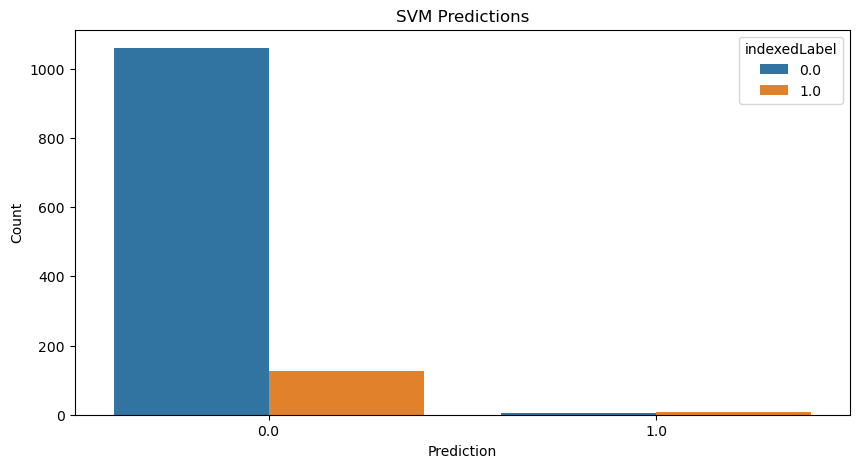

In [8]:
# Visualization for Linear SVM
pdf_svm = predictions_svm.select("prediction", "indexedLabel").toPandas()
plt.figure(figsize=(10, 5))
sns.countplot(x="prediction", hue="indexedLabel", data=pdf_svm)
plt.title("SVM Predictions")
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.show()

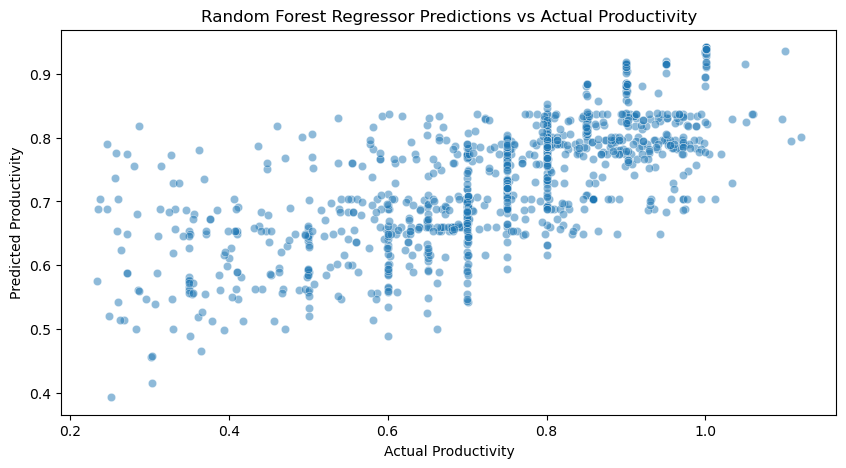

In [9]:
# Visualization for Random Forest Regressor
pdf_rf_regressor = predictions_rf_regressor.select("prediction", "actual_productivity").toPandas()
plt.figure(figsize=(10, 5))
sns.scatterplot(x="actual_productivity", y="prediction", data=pdf_rf_regressor, alpha=0.5)
plt.title("Random Forest Regressor Predictions vs Actual Productivity")
plt.xlabel("Actual Productivity")
plt.ylabel("Predicted Productivity")
plt.show()

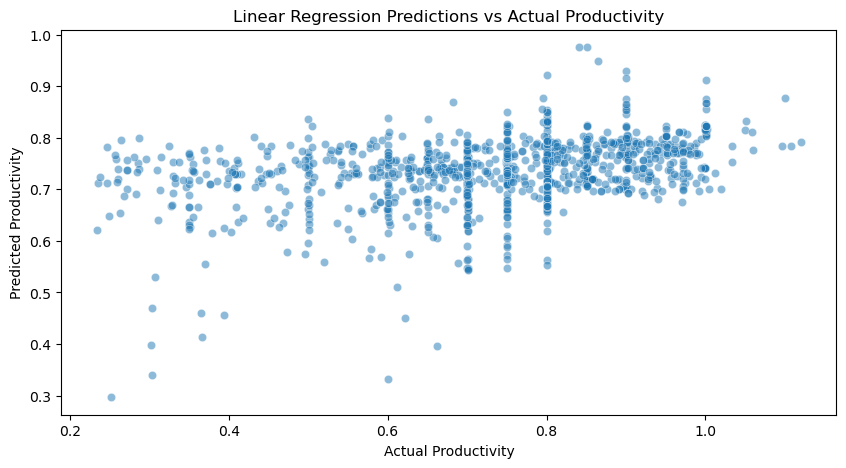

In [10]:
# Visualization for Linear Regression
pdf_lr = predictions_lr.select("prediction", "actual_productivity").toPandas()
plt.figure(figsize=(10, 5))
sns.scatterplot(x="actual_productivity", y="prediction", data=pdf_lr, alpha=0.5)
plt.title("Linear Regression Predictions vs Actual Productivity")
plt.xlabel("Actual Productivity")
plt.ylabel("Predicted Productivity")
plt.show()